In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import warnings
from tqdm import tqdm
import numpy as np
import requests
from matplotlib import pyplot as plt
# Suppress warnings from statsmodels and other sources
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

# Load your dataset
data = pd.read_csv('new_concepts_edges_data.csv')

# Define columns to check for zeros
columns_with_zeros = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

# Remove rows where any of the specified columns contain zeros
cleaned_data = data.loc[~(data[columns_with_zeros] == 0).any(axis=1)]

# Save the cleaned dataset
cleaned_data.to_csv('new_concepts_edges_data.csv', index=False)


# Time Series

In [3]:
# Load the dataset
file_path = 'new_concepts_edges_data.csv'
data = pd.read_csv(file_path)

In [4]:
# Convert year columns to float for consistent datatype
year_columns = [str(year) for year in range(2013, 2024)]
data[year_columns] = data[year_columns].astype(float)
data.fillna(method='ffill', inplace=True)

In [10]:
cumsum_data = data.loc[:, year_columns].cumsum(axis=1)
cumsum_data

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,5.0,12.0,18.0,25.0,28.0,36.0,44.0,55.0,60.0,62.0,67.0
1,91.0,174.0,282.0,453.0,619.0,781.0,919.0,1055.0,1180.0,1312.0,1424.0
2,194.0,398.0,601.0,801.0,962.0,1163.0,1341.0,1541.0,1765.0,1946.0,2093.0
3,446.0,864.0,1272.0,1705.0,2118.0,2533.0,2942.0,3402.0,3932.0,4425.0,4912.0
4,574451.0,1157491.0,1729364.0,2296441.0,2875287.0,3502193.0,4152312.0,4846534.0,5561566.0,6234157.0,6948584.0
...,...,...,...,...,...,...,...,...,...,...,...
1856,16.0,36.0,57.0,72.0,94.0,109.0,136.0,159.0,176.0,194.0,212.0
1857,19.0,48.0,63.0,82.0,100.0,128.0,156.0,184.0,212.0,244.0,288.0
1858,34.0,79.0,115.0,144.0,180.0,221.0,247.0,281.0,308.0,323.0,351.0
1859,39.0,57.0,76.0,104.0,141.0,179.0,196.0,215.0,238.0,255.0,277.0


In [19]:
# Initialize a DataFrame to store the results
results = []

# Process each pair of concepts
for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing Concepts"):
    concept_a = row['ConceptA']
    concept_b = row['ConceptB']

    # Extract the time series data
    ts_data = row[year_columns].cumsum()

    # Ensure ts_data is all floats and reshape appropriately for ARIMA
    ts_data = ts_data.astype(float).values.reshape(-1)  # Reshape data to fit ARIMA

    # Fit ARIMA model on cumulative data (excluding the last year for training)
    model = ARIMA(ts_data[:-1], order=(1,0,1))
    fitted_model = model.fit()

    # Forecast the next year
    forecast = fitted_model.forecast(steps=1)
    actual_cumulative = ts_data[-1]

    # Error calculations
    absolute_error = abs(forecast[0] - actual_cumulative)
    percentage_error = (absolute_error / actual_cumulative) * 100

    # Store results
    results.append({
    'ConceptA': concept_a,
    'ID_A': row['ID_ConceptA'],
    'ConceptB': concept_b,
    'ID_B': row['ID_ConceptB'],
    'Forecasted Cumulative Count': forecast[0],
    'Actual Cumulative Count': actual_cumulative,
    'Absolute Error': absolute_error,
    'Percentage Error': percentage_error
    })


# Convert results to DataFrame and output
results_df = pd.DataFrame(results)
results_df.to_csv('edge_forecast_results.csv', index=False)

Processing Concepts:   0%|          | 0/1861 [00:00<?, ?it/s]

Processing Concepts:  55%|█████▌    | 1028/1861 [01:02<00:50, 16.36it/s]


KeyboardInterrupt: 

In [ ]:
results_df1

In [7]:
results_df

,ConceptA,ID_A,ConceptB,ID_B,Forecasted Cumulative Count,Actual Cumulative Count,Absolute Error,Percentage Error
0,Mechanical engineering,C78519656,Safety engineering,C94279714,6.230084e+01,67.0,4.699164,7.013677
1,Mechanical engineering,C78519656,Industrial and production engineering,C2776865271,1.385775e+03,1424.0,38.224991,2.684339
2,Electrical engineering,C119599485,Industrial and production engineering,C2776865271,2.025314e+03,2093.0,67.686227,3.233933
3,Electrical engineering,C119599485,Communications system,C101765175,4.623305e+03,4912.0,288.695339,5.877348
4,Computer science,C41008148,Mathematics,C33923547,6.433285e+06,6948584.0,515298.911466,7.415884
...,...,...,...,...,...,...,...,...
1856,Cognitive science,C188147891,Scientific modelling,C138379479,1.965490e+02,212.0,15.450953,7.288185
1857,Cognitive science,C188147891,Dynamical systems theory,C79379906,2.590840e+02,288.0,28.916039,10.040291
1858,Cognitive science,C188147891,Neuroeconomics,C188660851,3.326462e+02,351.0,18.353823,5.229009
1859,Cognitive science,C188147891,Folk psychology,C128482177,2.636359e+02,277.0,13.364099,4.824585


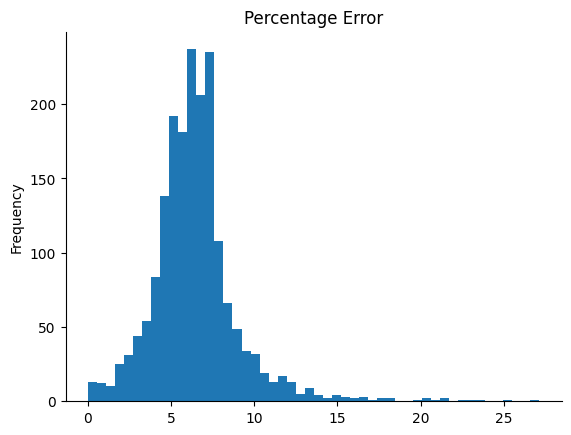

In [8]:
# @title Percentage Error


results_df['Percentage Error'].plot(kind='hist', bins=50, title='Percentage Error')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
# Calculate the mean percentage error
mean_percentage_error = results_df['Percentage Error'].mean()

# Print the mean percentage error
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")


Mean Percentage Error: 6.50%


## Graph preprocessing

In [10]:
forecasted_df = results_df[['ConceptA', 'ID_A', 'ConceptB', 'ID_B', 'Forecasted Cumulative Count']]
forecasted_df['Common Paper Count'] = forecasted_df['Forecasted Cumulative Count'] - cumsum_data['2022']
forecasted_df = forecasted_df[['ConceptA', 'ID_A', 'ConceptB', 'ID_B', 'Common Paper Count']]

forecasted_df

,ConceptA,ID_A,ConceptB,ID_B,Common Paper Count
0,Mechanical engineering,C78519656,Safety engineering,C94279714,0.300836
1,Mechanical engineering,C78519656,Industrial and production engineering,C2776865271,73.775009
2,Electrical engineering,C119599485,Industrial and production engineering,C2776865271,79.313773
3,Electrical engineering,C119599485,Communications system,C101765175,198.304661
4,Computer science,C41008148,Mathematics,C33923547,199128.088534
...,...,...,...,...,...
1856,Cognitive science,C188147891,Scientific modelling,C138379479,2.549047
1857,Cognitive science,C188147891,Dynamical systems theory,C79379906,15.083961
1858,Cognitive science,C188147891,Neuroeconomics,C188660851,9.646177
1859,Cognitive science,C188147891,Folk psychology,C128482177,8.635901


In [ ]:
forecasted_df.to_csv('graph_edge_data.csv')

In [25]:
# Calculate the most recent year from year_columns
most_recent_year = int(year_columns[-1])

# Initialize a dictionary to store the DataFrame results for each year
results_dict = {}

# Process data for endpoints from -1 to -9
for offset in range(1, 10):  # Adjust offset for clear understanding
    results = []
    year = most_recent_year - offset + 1  # Calculate the actual year for the filename
    desc = f"Processing for year {year}"

    # Process each pair of concepts
    for index, row in tqdm(data.iterrows(), total=data.shape[0], desc=desc):
        concept_a = row['ConceptA']
        concept_b = row['ConceptB']

        # Extract the time series data and calculate cumulative sums
        ts_data = row[year_columns].cumsum()

        # Ensure ts_data is all floats and reshape appropriately for ARIMA
        ts_data = ts_data.astype(float).values.reshape(-1)

        # Fit ARIMA model on cumulative data, excluding data beyond the current offset for training
        model = ARIMA(ts_data[:-offset], order=(1,0,1))
        fitted_model = model.fit()

        # Forecast the next year after the last year included in training
        forecast = fitted_model.forecast(steps=1)
        actual_cumulative = ts_data[-offset]

        # Calculate errors
        absolute_error = abs(forecast[0] - actual_cumulative)
        percentage_error = (absolute_error / actual_cumulative) * 100 if actual_cumulative != 0 else None

        # Store results
        results.append({
            'ConceptA': concept_a,
            'ID_A': row['ID_ConceptA'],
            'ConceptB': concept_b,
            'ID_B': row['ID_ConceptB'],
            'Forecasted Cumulative Count': forecast[0],
            'Actual Cumulative Count': actual_cumulative,
            'Absolute Error': absolute_error,
            'Percentage Error': percentage_error
        })

    # Convert results to DataFrame and store in dictionary
    results_dict[year] = pd.DataFrame(results)

# Export each DataFrame to a CSV file with the year as the filename
for year, df in results_dict.items():
    df.to_csv(f'edge_forecast_results_{year}.csv', index=False)

# Example on how to access results for the most recent year
print(results_dict[most_recent_year].head())

Processing for year 2015: 100%|██████████| 1861/1861 [03:32<00:00,  8.78it/s]


                 ConceptA        ID_A                               ConceptB  \
0  Mechanical engineering   C78519656                     Safety engineering   
1  Mechanical engineering   C78519656  Industrial and production engineering   
2  Electrical engineering  C119599485  Industrial and production engineering   
3  Electrical engineering  C119599485                  Communications system   
4        Computer science   C41008148                            Mathematics   

          ID_B  Forecasted Cumulative Count  Actual Cumulative Count  \
0    C94279714                 6.230084e+01                     67.0   
1  C2776865271                 1.385775e+03                   1424.0   
2  C2776865271                 2.025314e+03                   2093.0   
3   C101765175                 4.623305e+03                   4912.0   
4    C33923547                 6.433285e+06                6948584.0   

   Absolute Error  Percentage Error  
0        4.699164          7.013677  
1       38

In [28]:
mean_errors = {}

# Calculate the mean percentage error for each year's results
for year, df in results_dict.items():
    mean_percentage_error = df['Percentage Error'].mean()
    mean_errors[year] = mean_percentage_error

mean_errors_df = pd.DataFrame(list(mean_errors.items()), columns=['Year', 'Mean Percentage Error'])
print(mean_errors_df)

   Year  Mean Percentage Error
0  2023               6.501762
1  2022               7.207049
2  2021               8.527480
3  2020              11.291240
4  2019              10.962913
5  2018              12.710924
6  2017              21.573871
7  2016              60.539552
8  2015              66.003640


### 2024 Prediction

In [8]:
# Initialize a DataFrame to store the results
results = []

# Process each pair of concepts
for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing Concepts"):
    concept_a = row['ConceptA']
    concept_b = row['ConceptB']

    # Extract the time series data
    ts_data = row[year_columns].cumsum()

    # Ensure ts_data is all floats and reshape appropriately for ARIMA
    ts_data = ts_data.astype(float).values.reshape(-1)  # Reshape data to fit ARIMA

    # Fit ARIMA model on cumulative data (excluding the last year for training)
    model = ARIMA(ts_data, order=(1,0,1))
    fitted_model = model.fit()

    # Forecast the next year
    forecast = fitted_model.forecast(steps=1)

    # Store results
    results.append({
    'ConceptA': concept_a,
    'ID_A': row['ID_ConceptA'],
    'ConceptB': concept_b,
    'ID_B': row['ID_ConceptB'],
    'Forecasted Cumulative Count': forecast[0],
    })

Processing Concepts:   0%|          | 0/1861 [00:00<?, ?it/s]

Processing Concepts: 100%|██████████| 1861/1861 [02:05<00:00, 14.85it/s]


In [9]:
# Convert results to DataFrame and output
results_df = pd.DataFrame(results)
results_df

,ConceptA,ID_A,ConceptB,ID_B,Forecasted Cumulative Count
0,Mechanical engineering,C78519656,Safety engineering,C94279714,6.847358e+01
1,Mechanical engineering,C78519656,Industrial and production engineering,C2776865271,1.440640e+03
2,Electrical engineering,C119599485,Industrial and production engineering,C2776865271,2.130032e+03
3,Electrical engineering,C119599485,Communications system,C101765175,5.117083e+03
4,Computer science,C41008148,Mathematics,C33923547,7.170014e+06
...,...,...,...,...,...
1856,Cognitive science,C188147891,Scientific modelling,C138379479,2.195571e+02
1857,Cognitive science,C188147891,Dynamical systems theory,C79379906,3.060512e+02
1858,Cognitive science,C188147891,Neuroeconomics,C188660851,3.629057e+02
1859,Cognitive science,C188147891,Folk psychology,C128482177,2.854946e+02


In [12]:
forecasted_df = results_df[['ConceptA', 'ID_A', 'ConceptB', 'ID_B', 'Forecasted Cumulative Count']]
forecasted_df['Common Paper Count'] = abs(forecasted_df['Forecasted Cumulative Count'] - cumsum_data['2023'])
forecasted_df = forecasted_df[['ConceptA', 'ID_A', 'ConceptB', 'ID_B', 'Common Paper Count']]

forecasted_df

,ConceptA,ID_A,ConceptB,ID_B,Common Paper Count
0,Mechanical engineering,C78519656,Safety engineering,C94279714,1.473579
1,Mechanical engineering,C78519656,Industrial and production engineering,C2776865271,16.640153
2,Electrical engineering,C119599485,Industrial and production engineering,C2776865271,37.032011
3,Electrical engineering,C119599485,Communications system,C101765175,205.083397
4,Computer science,C41008148,Mathematics,C33923547,221430.467484
...,...,...,...,...,...
1856,Cognitive science,C188147891,Scientific modelling,C138379479,7.557144
1857,Cognitive science,C188147891,Dynamical systems theory,C79379906,18.051233
1858,Cognitive science,C188147891,Neuroeconomics,C188660851,11.905705
1859,Cognitive science,C188147891,Folk psychology,C128482177,8.494634


In [14]:
forecasted_df.to_csv('edge_forecast_results_2024.csv')